In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils

In [3]:
import tensorflow as tf
import numpy as np
import data
from model import build_model
import train
import matplotlib.pyplot as plt
from attributionpriors import eager_ops
import plot
from skimage import feature
import scipy

In [4]:
x_train, y_train, x_test, y_test = data.decoy_mnist(alter_test=False, alter_train=False)

In [5]:
random_model = build_model()

In [6]:
eg_saliency_total = eager_ops.expected_gradients_full(tf.constant(x_train[:1000]), x_train[1000:], random_model, k=100, 
                                                      index_true_class=True, labels=tf.one_hot(y_train[:1000], depth=10))

In [57]:
modified_x_train = x_train[:1000].copy()
for index in range(len(modified_x_train)):
    example = modified_x_train[index]
    example[np.logical_and(eg_saliency_total[index] > np.quantile(eg_saliency_total[0], q=0.75),
                       example == -0.5)] += y_train[index] / 50.0
    example[np.logical_and(eg_saliency_total[index] > np.quantile(eg_saliency_total[0], q=0.75),
                           example > 0.0)] -= y_train[index] / 50.0
    modified_x_train[index] = example

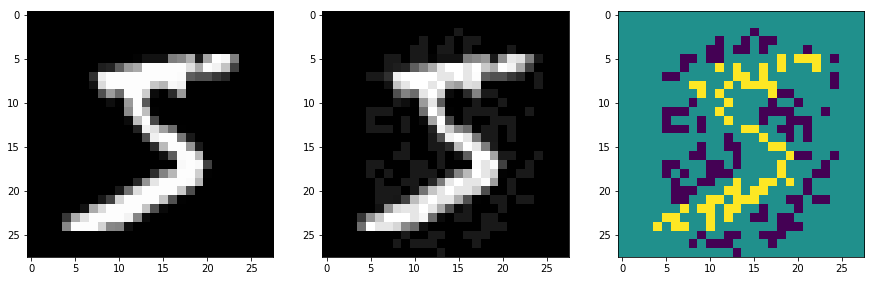

In [58]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(x_train[0, :, :, 0], cmap='gray')
axs[1].imshow(modified_x_train[0, :, :, 0], cmap='gray')
axs[2].imshow(x_train[0, :, :, 0] - modified_x_train[0, :, :, 0])

In [59]:
model = build_model()

In [60]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.fit(modified_x_train, y_train[:1000], 
          batch_size=50, 
          epochs=20, 
          validation_data=(x_test, y_test))

Train on 1000 samples, validate on 10000 samples
Epoch 1/20
1000/1000 [==============================] - 1s 889us/sample - loss: 1.7231 - sparse_categorical_accuracy: 0.4250 - val_loss: 1.2970 - val_sparse_categorical_accuracy: 0.5547
Epoch 2/20
1000/1000 [==============================] - 1s 589us/sample - loss: 1.0288 - sparse_categorical_accuracy: 0.6750 - val_loss: 0.8822 - val_sparse_categorical_accuracy: 0.7075
Epoch 3/20
1000/1000 [==============================] - 1s 593us/sample - loss: 0.5741 - sparse_categorical_accuracy: 0.8350 - val_loss: 0.8302 - val_sparse_categorical_accuracy: 0.7110
Epoch 4/20
1000/1000 [==============================] - 1s 595us/sample - loss: 0.4680 - sparse_categorical_accuracy: 0.8610 - val_loss: 0.5644 - val_sparse_categorical_accuracy: 0.8198
Epoch 5/20
1000/1000 [==============================] - 1s 605us/sample - loss: 0.3674 - sparse_categorical_accuracy: 0.8870 - val_loss: 0.5483 - val_sparse_categorical_accuracy: 0.8136
Epoch 6/20
1000/1000 

In [61]:
eg_saliency = eager_ops.expected_gradients_full(tf.constant(modified_x_train[0:10]), 
                                                    x_train, model, k=100, 
                                                    index_true_class=True,
                                                    labels=tf.one_hot(y_train[0:10], depth=10))

In [62]:
eg_saliency_random = eager_ops.expected_gradients_full(tf.constant(modified_x_train[0:10]), 
                                                    x_train, random_model, k=100, 
                                                    index_true_class=True,
                                                    labels=tf.one_hot(y_train[0:10], depth=10))

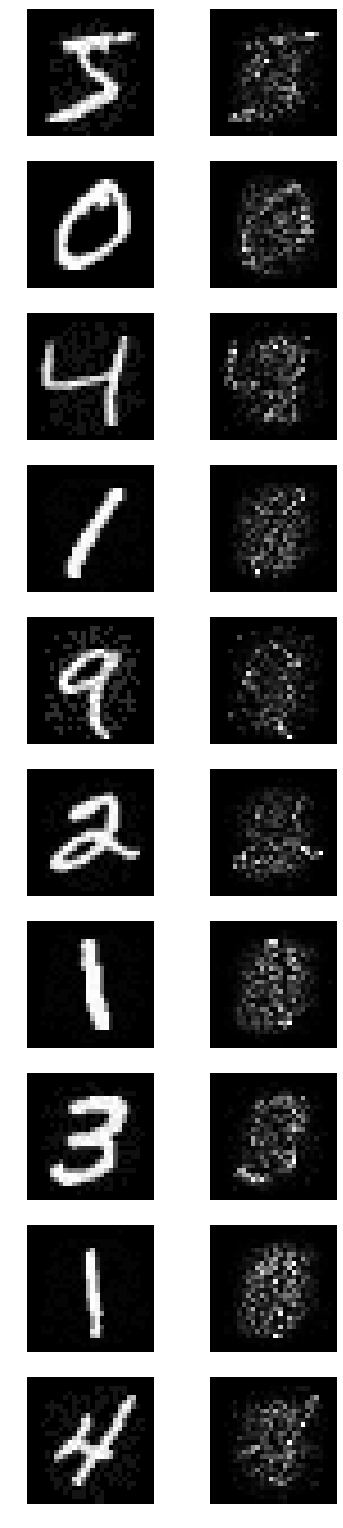

In [63]:
plot.image_plot(eg_saliency_random.numpy(), modified_x_train[:10], as_array=False, take_abs=True)

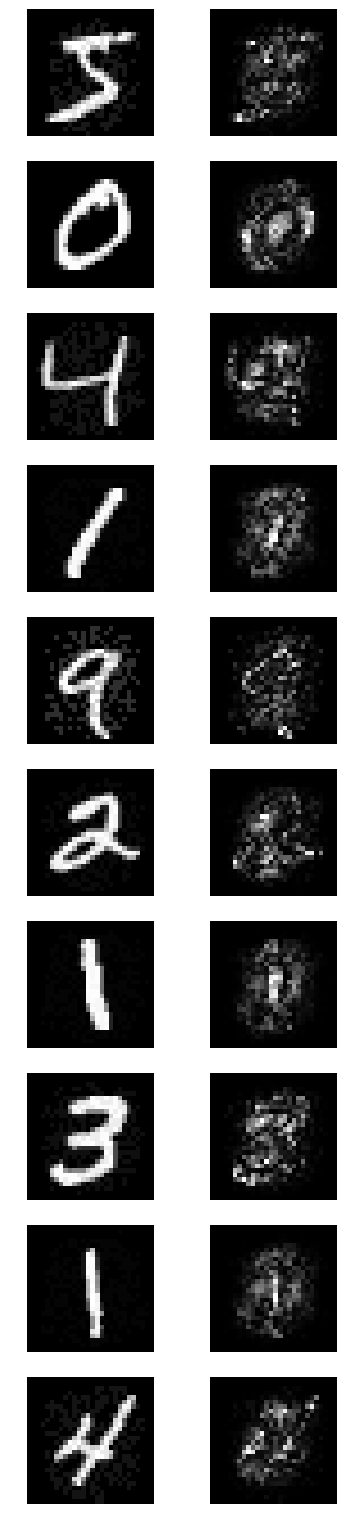

In [64]:
plot.image_plot(eg_saliency.numpy(), modified_x_train[:10], as_array=False, take_abs=True)

In [56]:
for c in range(10):
    index = np.where(y_train[:1000] == c)[0][0]
    
    eg_saliency = eager_ops.expected_gradients_full(tf.constant(modified_x_train[index:index+1]), 
                                                    x_train, model, k=100, 
                                                    index_true_class=True,
                                                    labels=tf.one_hot(y_train[:1000], depth=10))
    eg_saliency = np.abs(eg_saliency[0, :, :, 0])
    
    eg_saliency_random = eager_ops.expected_gradients_full(tf.constant(modified_x_train[index:index+1]), 
                                                    x_train, random_model, k=100, 
                                                    index_true_class=True,
                                                    labels=tf.one_hot(y_train[:1000], depth=10))
    eg_saliency_random = np.abs(eg_saliency_random[0, :, :, 0])
    
    utils.save_image(modified_x_train[index, :, :, 0], 'random_images/decoy{}.png'.format(c), minval=-0.5, maxval=0.5)
    utils.save_image(eg_saliency, 'random_images/saliency{}.png'.format(c), minval=0.0, maxval=np.max(eg_saliency))
    utils.save_image(eg_saliency_random, 'random_images/random_saliency{}.png'.format(c), minval=0.0, maxval=np.max(eg_saliency_random))